In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder = "/content/drive/MyDrive/Kaggle/Train/Train"
test_folder = "/content/drive/MyDrive/Kaggle/Test/Test"
val_folder= "/content/drive/MyDrive/Kaggle/Validation/Validation"

In [ ]:
def no_of_files(rootdir):
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
no_of_files(os.path.join(test_folder))

There are 50 files in Healthy
There are 50 files in Powdery
There are 50 files in Rust


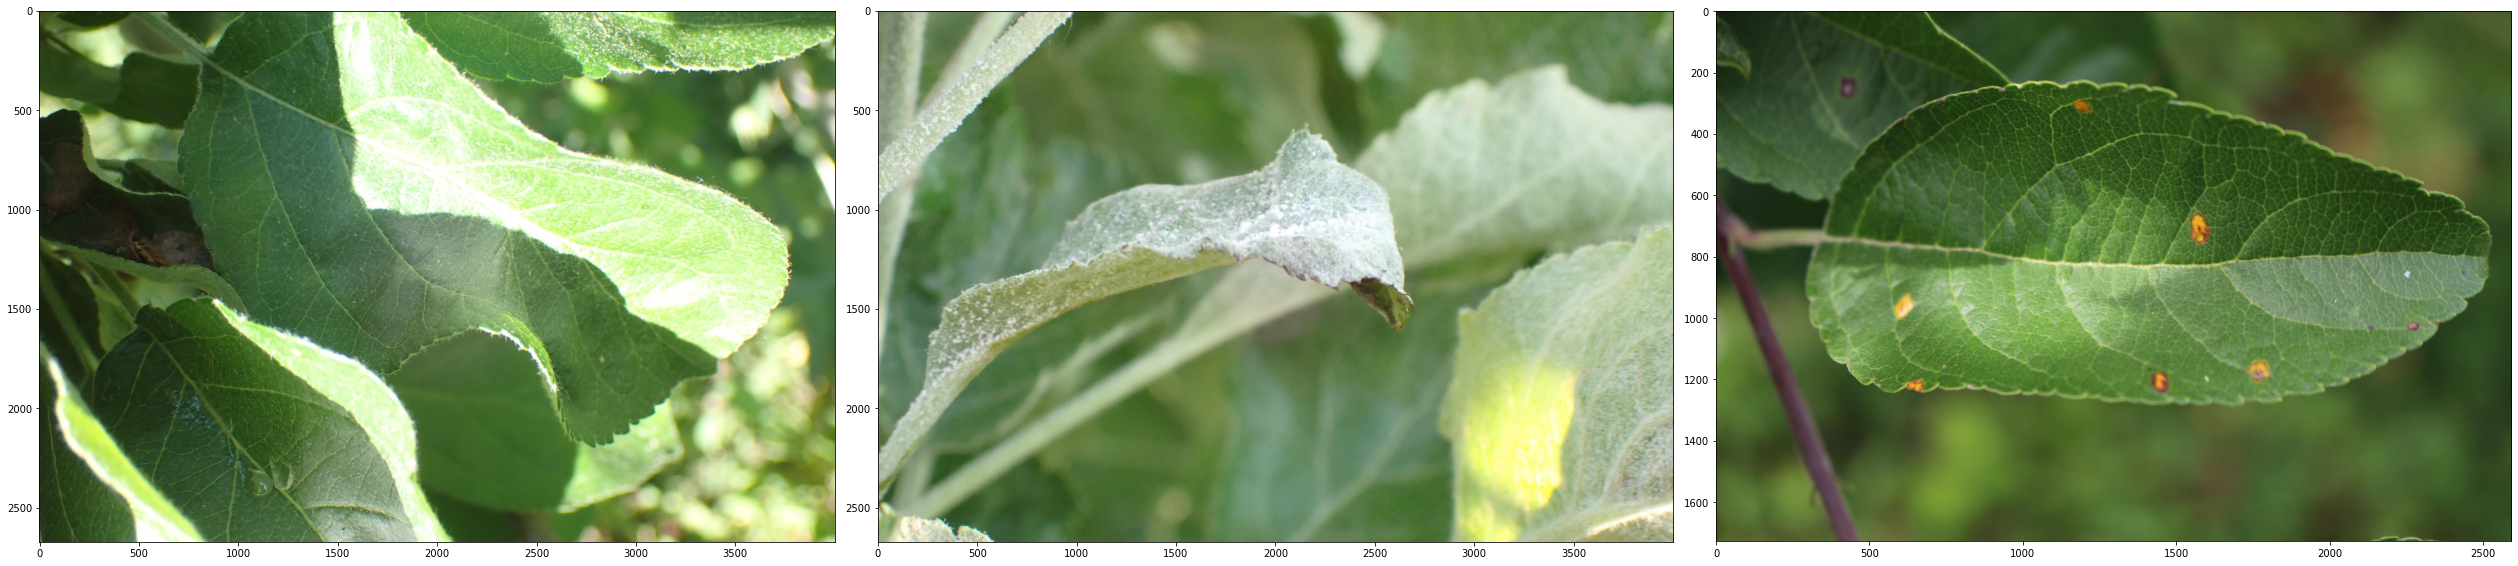

In [ ]:
images = []

for selected_folder in sorted(os.listdir(train_folder)):
    cell = os.listdir(train_folder + '/' + selected_folder)
    folder_selected = np.random.choice(cell)
    images.append(os.path.join(train_folder,selected_folder,folder_selected))
                                     
fig=plt.figure(1, figsize=(70, 50))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(6, 6, subplot+1)
    plt.imshow(imgs)
    
plt.tight_layout()

In [ ]:
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 48, 
    class_mode = 'categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
modelr=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in modelr.layers:
    layer.trainable=False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model=Sequential()
model.add(modelr)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [ ]:
optimizer=tf.keras.optimizers.Adam(lr=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
    
)

Epoch 1/15
28/28 [==============================] - 580s 20s/step - loss: 0.2512 - accuracy: 0.9123 - val_loss: 0.9058 - val_accuracy: 0.8867
Epoch 2/15
28/28 [==============================] - 380s 13s/step - loss: 0.0555 - accuracy: 0.9849 - val_loss: 0.6196 - val_accuracy: 0.8733
Epoch 3/15
28/28 [==============================] - 385s 14s/step - loss: 0.0221 - accuracy: 0.9939 - val_loss: 0.5245 - val_accuracy: 0.8933
Epoch 4/15
28/28 [==============================] - 379s 13s/step - loss: 0.0116 - accuracy: 0.9977 - val_loss: 0.4860 - val_accuracy: 0.8800
Epoch 5/15
28/28 [==============================] - 386s 14s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4220 - val_accuracy: 0.8933
Epoch 6/15
28/28 [==============================] - 382s 13s/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 0.3684 - val_accuracy: 0.9067
Epoch 7/15
28/28 [==============================] - 380s 14s/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.3553 - val_accuracy: 0.9067
Epoch 

In [ ]:
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='lower right')

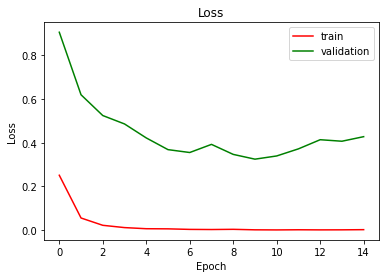

In [ ]:
plt.plot(history.history['loss'],c='red')
plt.plot(history.history['val_loss'],c='green')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')

In [ ]:
model.evaluate(test_set)

4/4 [==============================] - 40s 8s/step - loss: 0.4278 - accuracy: 0.8933


[0.4277936816215515, 0.8933333158493042]

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array

In [ ]:
dic=training_set.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    predict_x=model.predict(test_set) 
    classes_x=np.argmax(predict_x,axis=1)
    print ('Predicted Class',icd[classes_x[0]])

4/4 [==============================] - 42s 8s/step
Predicted Class Healthy


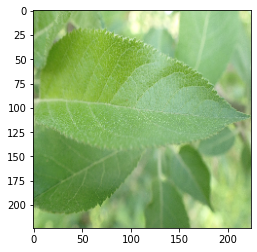

In [ ]:
test_img='/content/drive/MyDrive/Kaggle/Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg'
pic=load_img(test_img,target_size=(224,224,3))
plt.imshow(pic)
output(test_img)

In [ ]:
import pickle

In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('capstone_model_4.pkl', 'wb'))

[INFO] Saving model...
